# Referencias

**FeatureTools**  

> https://featuretools.alteryx.com/en/stable/  

**Medium** -> Usar luego un arbol para clasificar

> https://ranasinghiitkgp.medium.com/feature-engineering-using-featuretools-with-code-10f8c83e5f68

**Demo**

> https://chatgpt.com/share/8ec15bc1-781c-475d-b356-64576f3ad47f
  

>Hola Nicole,En primer lugar, ¡bienvenida a la empresa!Hablando con Michelle, hemos pensado que sería ideal que pudiéramos identificar grupos de productos que se comportan de manera similar. Michelle estaba diciendo que con tu magia es fácil identificar grupos de productos similares, y tales grupos serán súper útiles para evaluar el rendimiento de nuestras diferentes campañas. ¿Cuántos grupos crees que deberíamos considerar? 5? 10? 20? Además, ¿crees que podríamos encontrar un enfoque ”similar" para identificar cómo de similares son las tiendas entre sí? ¿La agrupación de tiendas también tendría sentido aquí? ¿Podrías hacer eso también?¡Me alegra que finalmente podamos contar con alguien con tus habilidades dentro del equipo! Saludos -- <cite>- Joelle</cite>

___

# INIT

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns',100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',100)

In [2]:
# Conectar a db
import os
import pymongo
from dotenv import load_dotenv

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Obtener la URI de MongoDB desde las variables de entorno
URI = os.getenv('LOCAL.URI')

# print(f'URI: {URI}')
# Verificar si la URI se ha cargado correctamente
if not URI:
    raise ValueError("No se ha encontrado la URI de MongoDB en las variables de entorno")

try:
    # Conéctate a tu servidor MongoDB
    client = pymongo.MongoClient(URI, serverSelectionTimeoutMS=5000)  
    
    # Prueba la conexión
    client.server_info()  # Esto lanzará una excepción si no puede conectarse
    print("Conexión exitosa")
    
    # Selecciona la base de datos y las colecciones
    db = client['ds_market']

except Exception as e:
    print(f"Error de conexión: {e}")

Conexión exitosa


In [3]:
def get_collection(collect_name):
    # Leemos coleccion que queremos y guardamos en dataframe
    collection = db[collect_name]

    # Contar el número de documentos en la colección
    document_count = collection.count_documents({})

    print(f"El número de documentos en la {collect_name} es: {document_count}")

    # Leer la colección
    docs = collection.find()

    # Convertir los docs a una lista
    list_docs = list(docs)

    # Convertir la lista de docs a un DataFrame de pandas
    _df = pd.DataFrame(list_docs)

    return _df

In [4]:
db_collections = [
    'calendar',
    'items',
    'prices',
    'tiendas',
    'departments',
    'sales_main',
    'weekly_sales',
    'year_sales',
    'day_sales'
    ]

In [5]:
df_cal = get_collection('calendar').drop(columns='_id')
df_cal = df_cal.fillna('None') # event tiene NaN

# Añadimos columnas week y month a calendar para hacer cruces de datos mas faciles
'''
# DONE
calendar_collection = db['calendar']

display(df_cal.head())

df_cal['date'] = pd.to_datetime(df_cal['date'])

# Añadimos numero de mes
df_cal['month'] = df_cal['date'].dt.month

# Añadimos semana
df_cal['week'] = df_cal['date'].dt.isocalendar().week

# Rellenamos NaN con str 'None'
df_cal['event'] = df_cal['event'].fillna('None')

# Itera sobre las filas del DataFrame y actualiza los documentos en la colección 'calendar'
for index, row in df_cal.iterrows():
    # Define los campos a actualizar
    update_fields = {
        'week': row['week'],
        'month': row['month']
    }
    
    # Actualiza el documento con los nuevos campos
    calendar_collection.update_one({'_id': row['_id']}, {'$set': update_fields})

# Imprime un mensaje de finalización
print('Actualización completada')
'''

El número de documentos en la calendar es: 1913


"\n# DONE\ncalendar_collection = db['calendar']\n\ndisplay(df_cal.head())\n\ndf_cal['date'] = pd.to_datetime(df_cal['date'])\n\n# Añadimos numero de mes\ndf_cal['month'] = df_cal['date'].dt.month\n\n# Añadimos semana\ndf_cal['week'] = df_cal['date'].dt.isocalendar().week\n\n# Rellenamos NaN con str 'None'\ndf_cal['event'] = df_cal['event'].fillna('None')\n\n# Itera sobre las filas del DataFrame y actualiza los documentos en la colección 'calendar'\nfor index, row in df_cal.iterrows():\n    # Define los campos a actualizar\n    update_fields = {\n        'week': row['week'],\n        'month': row['month']\n    }\n    \n    # Actualiza el documento con los nuevos campos\n    calendar_collection.update_one({'_id': row['_id']}, {'$set': update_fields})\n\n# Imprime un mensaje de finalización\nprint('Actualización completada')\n"

In [6]:
df_shops = get_collection('tiendas').drop(columns='_id')
df_items = get_collection('items').drop(columns='_id')

df_ws = get_collection('weekly_sales').drop(columns='_id')

# Añadimos eventos para no perder esa información
# Crear un diccionario desde df_cal
event_dict = df_cal.set_index('week')['event'].to_dict()

# Añadir la columna 'event' a df_ws usando el método 'map'
df_ws['event'] = df_ws['week'].map(event_dict)

El número de documentos en la tiendas es: 10
El número de documentos en la items es: 3049
El número de documentos en la weekly_sales es: 5016091


# Clustering Productos

## 1. Librerias

In [9]:
import featuretools as ft
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Creacion de caracteristicas

In [ ]:
display(df_items.head(3), df_shops.head(3), df_ws.head(3))

,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca


,item,store_code,year,week,units,sell_price,raw_earn,event,index
0,SUPERMARKET_2_335,NYC_4,2011,14,3,4.54,13.61,None,0
1,SUPERMARKET_2_359,NYC_3,2011,26,28,2.36,66.19,None,1
2,SUPERMARKET_2_359,NYC_3,2011,25,18,2.36,42.55,None,2


In [ ]:
# Añadir una columna 'index' si no existe
df_ws['index'] = df_ws.index # Para que?

# Crear un EntitySet
es = ft.EntitySet(id="retail")

# # Añadir los DataFrames al EntitySet
# es = es.add_dataframe(dataframe_name="ws", dataframe=df_ws, index="index")
# es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
# es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")

# Añadir las tablas al EntitySet
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="weekly_sales", dataframe=df_ws, index="index")

# Definir las relaciones entre tablas
es = es.add_relationship("shops", "store_code", "weekly_sales", "store_code")
es = es.add_relationship("items", "item", "weekly_sales", "item")

# # Definir relaciones
# relationship1 = ft.Relationship(es["items"]["item"], es["weekly_sales"]["item"])
# relationship2 = ft.Relationship(es["shops"]["store_code"], es["weekly_sales"]["store_code"])

# # Añadir relaciones al EntitySet
# es = es.add_relationship(relationship1)
# es = es.add_relationship(relationship2)

In [ ]:
# Generar características automáticamente
feature_matrix_products, feature_defs_products = ft.dfs(
    entityset=es,
    target_dataframe_name="items",
    max_depth=2,
    verbose = 1, 
    n_jobs = 1
    )

# Mostrar el feature matrix generado
display(feature_matrix_products.shape)

feature_matrix_products.head()

Built 35 features
Elapsed: 00:01 | Progress:   0%|          

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function std at 0x000002BA1B5F3100> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  ).agg(to_agg)
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x000002BA1B5F2FC0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Py

Elapsed: 00:08 | Progress: 100%|██████████


(3049, 35)

,category,department,COUNT(weekly_sales),MAX(weekly_sales.raw_earn),MAX(weekly_sales.sell_price),MAX(weekly_sales.units),MAX(weekly_sales.week),MAX(weekly_sales.year),MEAN(weekly_sales.raw_earn),MEAN(weekly_sales.sell_price),MEAN(weekly_sales.units),MEAN(weekly_sales.week),MEAN(weekly_sales.year),MIN(weekly_sales.raw_earn),MIN(weekly_sales.sell_price),MIN(weekly_sales.units),MIN(weekly_sales.week),MIN(weekly_sales.year),MODE(weekly_sales.event),NUM_UNIQUE(weekly_sales.event),SKEW(weekly_sales.raw_earn),SKEW(weekly_sales.sell_price),SKEW(weekly_sales.units),SKEW(weekly_sales.week),SKEW(weekly_sales.year),STD(weekly_sales.raw_earn),STD(weekly_sales.sell_price),STD(weekly_sales.units),STD(weekly_sales.week),STD(weekly_sales.year),SUM(weekly_sales.raw_earn),SUM(weekly_sales.sell_price),SUM(weekly_sales.units),SUM(weekly_sales.week),SUM(weekly_sales.year)
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,1185,142.82,12.74,13.00,53.00,2016.00,38.15,11.01,3.45,27.13,2014.46,10.99,6.65,1.00,1.00,2013.00,None,3,1.15,-7.11,1.16,-0.06,-0.02,24.62,0.19,2.24,15.69,0.90,44559.73,12862.35,4093.00,32148.00,2387135.00
ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1899,190.08,5.28,36.00,53.00,2016.00,14.09,5.28,2.66,27.79,2013.29,2.66,2.66,1.00,1.00,2011.00,None,3,4.29,-27.27,4.29,-0.12,0.04,11.68,0.09,2.21,15.15,1.46,26639.47,9972.82,5059.00,52774.00,3823243.00
ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,665,63.20,3.95,16.00,53.00,2016.00,8.51,3.94,2.16,23.95,2014.91,1.29,1.25,1.00,1.00,2014.00,None,3,3.07,-14.65,3.05,0.34,0.12,6.44,0.18,1.63,15.02,0.68,5533.73,2559.51,1435.00,15927.00,1339914.00
ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2512,506.04,6.17,82.00,53.00,2016.00,94.17,5.99,15.60,25.86,2013.22,5.01,5.01,1.00,1.00,2011.00,None,3,1.40,-1.67,1.35,0.08,0.07,79.00,0.27,12.96,15.16,1.52,234283.92,14892.93,39175.00,64962.00,5057201.00
ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,2134,141.61,4.10,42.00,53.00,2016.00,26.19,3.83,6.85,27.07,2013.46,3.30,2.65,1.00,1.00,2011.00,None,3,1.55,-0.80,1.78,-0.06,-0.11,18.45,0.23,4.94,15.36,1.52,55310.59,8079.94,14621.00,57757.00,4296731.00


In [ ]:
# Obtener descripciones de las características
# for desc in feature_defs_products:
#     feat_desc = ft.describe_feature(desc)
    # print(feat_desc)

## 3. Estandarizacion y Normalizacion

In [ ]:
# Identificar columnas categóricas y numéricas
categorical_columns = feature_matrix_products.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_columns = feature_matrix_products.select_dtypes(include=[float, int]).columns.tolist()

# Crear el preprocesador que aplicará OneHotEncoder a las categóricas y RobustScaler a las numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)  # 'drop=first' evita multicolinealidad
    ]
)

# Aplicar las transformaciones utilizando el preprocesador
scaled_features = preprocessor.fit_transform(feature_matrix_products)

# Obtener el nombre de las columnas después de la transformación
encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_columns = numeric_columns + encoded_columns.tolist()

# Convertir el resultado de nuevo a un DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=all_columns)

# Mostrar el DataFrame transformado
display(scaled_df.shape)
scaled_df.head()


(3049, 40)

,COUNT(weekly_sales),MAX(weekly_sales.raw_earn),MAX(weekly_sales.sell_price),MAX(weekly_sales.units),MAX(weekly_sales.week),MAX(weekly_sales.year),MEAN(weekly_sales.raw_earn),MEAN(weekly_sales.sell_price),MEAN(weekly_sales.units),MEAN(weekly_sales.week),MEAN(weekly_sales.year),MIN(weekly_sales.raw_earn),MIN(weekly_sales.sell_price),MIN(weekly_sales.units),MIN(weekly_sales.week),MIN(weekly_sales.year),NUM_UNIQUE(weekly_sales.event),SKEW(weekly_sales.raw_earn),SKEW(weekly_sales.sell_price),SKEW(weekly_sales.units),SKEW(weekly_sales.week),SKEW(weekly_sales.year),STD(weekly_sales.raw_earn),STD(weekly_sales.sell_price),STD(weekly_sales.units),STD(weekly_sales.week),STD(weekly_sales.year),SUM(weekly_sales.raw_earn),SUM(weekly_sales.sell_price),SUM(weekly_sales.units),SUM(weekly_sales.week),SUM(weekly_sales.year),category_HOME_&_GARDEN,category_SUPERMARKET,department_ACCESORIES_2,department_HOME_&_GARDEN_1,department_HOME_&_GARDEN_2,department_SUPERMARKET_1,department_SUPERMARKET_2,department_SUPERMARKET_3
0,-0.50,-0.03,1.81,-0.39,0.00,0.00,0.38,1.50,-0.30,1.09,0.97,2.03,1.14,0.00,0.00,2.00,0.00,-0.63,-0.88,-0.64,-1.17,-0.41,0.24,0.21,-0.35,0.70,-1.02,0.02,0.86,-0.32,-0.44,-0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.21,0.23,0.19,0.06,0.00,0.00,-0.43,0.24,-0.40,1.74,-0.18,-0.18,0.05,0.00,0.00,0.00,0.00,3.53,-3.94,3.44,-1.69,-0.06,-0.35,-0.23,-0.36,-0.21,0.01,-0.27,0.47,-0.26,0.34,0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-1.01,-0.48,-0.10,-0.33,0.00,0.00,-0.62,-0.05,-0.46,-2.03,1.41,-0.54,-0.33,0.00,0.00,3.00,0.00,1.92,-2.02,1.82,2.37,0.34,-0.59,0.19,-0.45,-0.44,-1.41,-0.61,-0.52,-0.47,-1.05,-1.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.82,1.99,0.38,0.96,0.00,0.00,2.28,0.40,1.23,-0.15,-0.26,0.45,0.70,0.00,0.00,0.00,0.00,-0.30,-0.05,-0.38,0.11,0.06,2.72,0.58,1.43,-0.19,0.13,3.10,1.13,1.73,0.81,0.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.44,-0.04,-0.07,0.18,0.00,0.00,-0.02,-0.08,0.13,1.03,-0.01,-0.01,0.05,0.00,0.00,0.00,0.00,-0.10,0.08,0.17,-1.19,-0.84,-0.04,0.40,0.10,0.15,0.12,0.20,0.22,0.30,0.53,0.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
if scaled_df.isna().sum().sum() > 0:
    scaled_df = scaled_df.dropna()
else:
    print('No hay nulos')


No hay nulos


In [ ]:
scaled_df.shape

(3049, 40)

# 4. KMEANS

### 4.0 Modelo + Elbow + Shilouette

Inertia 212311.76650311032 for 1
Inertia 157207.0344167396 for 2
Inertia 134791.535224004 for 3
Inertia 123503.00831495065 for 4
Inertia 116768.61196054428 for 5
Inertia 110518.66534447347 for 6
Inertia 105988.8191683421 for 7
Inertia 95776.7977904526 for 8
Inertia 85766.6398413486 for 9
Inertia 84266.32221796851 for 10
Inertia 82692.69426465523 for 11
Inertia 80263.53048626319 for 12
Inertia 75913.79168198173 for 13
Inertia 71450.31292885762 for 14
Inertia 68509.34658242288 for 15
Inertia 65960.48871449471 for 16
Inertia 63153.203787775434 for 17
Inertia 61233.29094558388 for 18
Inertia 58974.9950313188 for 19
Inertia 58657.42156202735 for 20
Inertia 56183.709199296085 for 21
Inertia 55425.93992312928 for 22
Inertia 54611.54527603195 for 23
Inertia 52958.288022795896 for 24
Inertia 52142.46991650216 for 25
Inertia 51693.106053959695 for 26
Inertia 51131.141067463985 for 27
Inertia 50332.82289544635 for 28
Inertia 48711.28289834322 for 29
Inertia 47965.39631259863 for 30


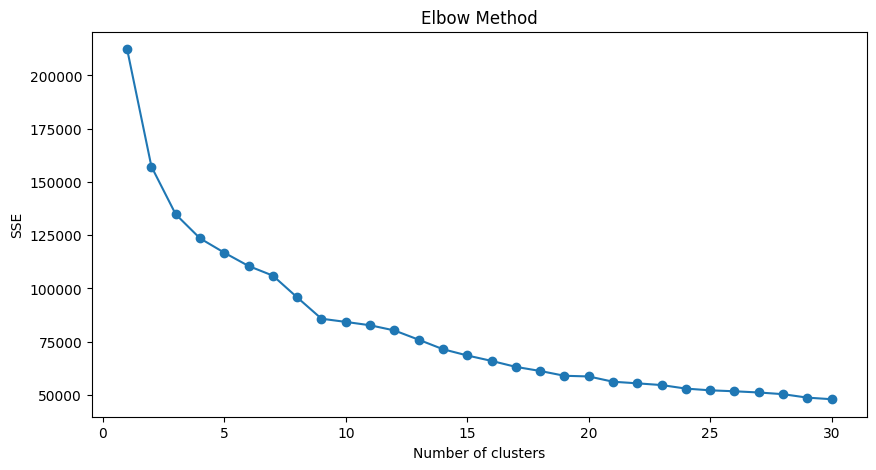

In [35]:
# Elbow Method
max_range = 31
sse = []
for k in range(1, max_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    print(f"Inertia {kmeans.inertia_} for {k}")
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, max_range), sse, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

Silhouette Score avg: 0.7061658126231478 for 2
Silhouette Score avg: 0.46594267648135734 for 3
Silhouette Score avg: 0.26717289848661396 for 4
Silhouette Score avg: 0.1371587464707501 for 5
Silhouette Score avg: 0.1441353733530394 for 6
Silhouette Score avg: 0.14890676872148245 for 7
Silhouette Score avg: 0.14858644212037644 for 8
Silhouette Score avg: 0.15002837293630142 for 9
Silhouette Score avg: 0.15204917256177738 for 10
Silhouette Score avg: 0.15193688768782798 for 11
Silhouette Score avg: 0.1520552581166597 for 12
Silhouette Score avg: 0.15580279813779857 for 13
Silhouette Score avg: 0.14784220556605138 for 14
Silhouette Score avg: 0.15604393617493326 for 15
Silhouette Score avg: 0.16029807799717508 for 16
Silhouette Score avg: 0.16606561444786413 for 17
Silhouette Score avg: 0.1608776455988349 for 18
Silhouette Score avg: 0.15783203480460978 for 19
Silhouette Score avg: 0.13793495823461976 for 20
Silhouette Score avg: 0.13002189678634446 for 21
Silhouette Score avg: 0.127963877

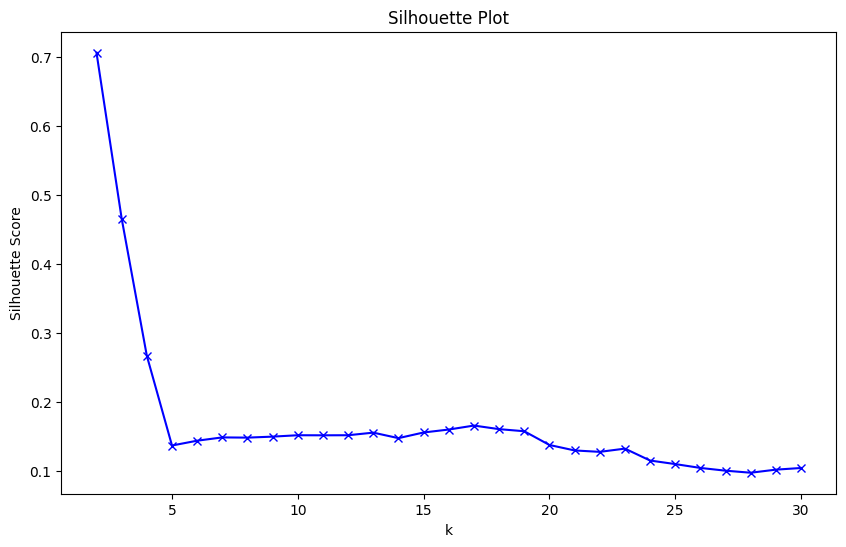

In [36]:
# Silhouette Plot
silhouette_scores = []
for k in range(2, max_range):  # Empieza desde 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    print(f"Silhouette Score avg: {score} for {k}")
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_range), silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Plot')
plt.show()

In [37]:
# Aplicar K-Means con el número óptimo de clusters
optimal_k = 5  # Según shiloutte

kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Ajustar el modelo
kmeans.fit(scaled_df)

# Asignar etiquetas de cluster a cada producto
feature_matrix_products['Cluster'] = kmeans.labels_

display(feature_matrix_products.head())

,category,department,COUNT(weekly_sales),MAX(weekly_sales.raw_earn),MAX(weekly_sales.sell_price),MAX(weekly_sales.units),MAX(weekly_sales.week),MAX(weekly_sales.year),MEAN(weekly_sales.raw_earn),MEAN(weekly_sales.sell_price),MEAN(weekly_sales.units),MEAN(weekly_sales.week),MEAN(weekly_sales.year),MIN(weekly_sales.raw_earn),MIN(weekly_sales.sell_price),MIN(weekly_sales.units),MIN(weekly_sales.week),MIN(weekly_sales.year),MODE(weekly_sales.event),NUM_UNIQUE(weekly_sales.event),SKEW(weekly_sales.raw_earn),SKEW(weekly_sales.sell_price),SKEW(weekly_sales.units),SKEW(weekly_sales.week),SKEW(weekly_sales.year),STD(weekly_sales.raw_earn),STD(weekly_sales.sell_price),STD(weekly_sales.units),STD(weekly_sales.week),STD(weekly_sales.year),SUM(weekly_sales.raw_earn),SUM(weekly_sales.sell_price),SUM(weekly_sales.units),SUM(weekly_sales.week),SUM(weekly_sales.year),Cluster
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,1185,142.82,12.74,13.00,53.00,2016.00,38.15,11.01,3.45,27.13,2014.46,10.99,6.65,1.00,1.00,2013.00,None,3,1.15,-7.11,1.16,-0.06,-0.02,24.62,0.19,2.24,15.69,0.90,44559.73,12862.35,4093.00,32148.00,2387135.00,2
ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1899,190.08,5.28,36.00,53.00,2016.00,14.09,5.28,2.66,27.79,2013.29,2.66,2.66,1.00,1.00,2011.00,None,3,4.29,-27.27,4.29,-0.12,0.04,11.68,0.09,2.21,15.15,1.46,26639.47,9972.82,5059.00,52774.00,3823243.00,4
ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,665,63.20,3.95,16.00,53.00,2016.00,8.51,3.94,2.16,23.95,2014.91,1.29,1.25,1.00,1.00,2014.00,None,3,3.07,-14.65,3.05,0.34,0.12,6.44,0.18,1.63,15.02,0.68,5533.73,2559.51,1435.00,15927.00,1339914.00,2
ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2512,506.04,6.17,82.00,53.00,2016.00,94.17,5.99,15.60,25.86,2013.22,5.01,5.01,1.00,1.00,2011.00,None,3,1.40,-1.67,1.35,0.08,0.07,79.00,0.27,12.96,15.16,1.52,234283.92,14892.93,39175.00,64962.00,5057201.00,0
ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,2134,141.61,4.10,42.00,53.00,2016.00,26.19,3.83,6.85,27.07,2013.46,3.30,2.65,1.00,1.00,2011.00,None,3,1.55,-0.80,1.78,-0.06,-0.11,18.45,0.23,4.94,15.36,1.52,55310.59,8079.94,14621.00,57757.00,4296731.00,4


### 4.1 Descripcion de los clusters

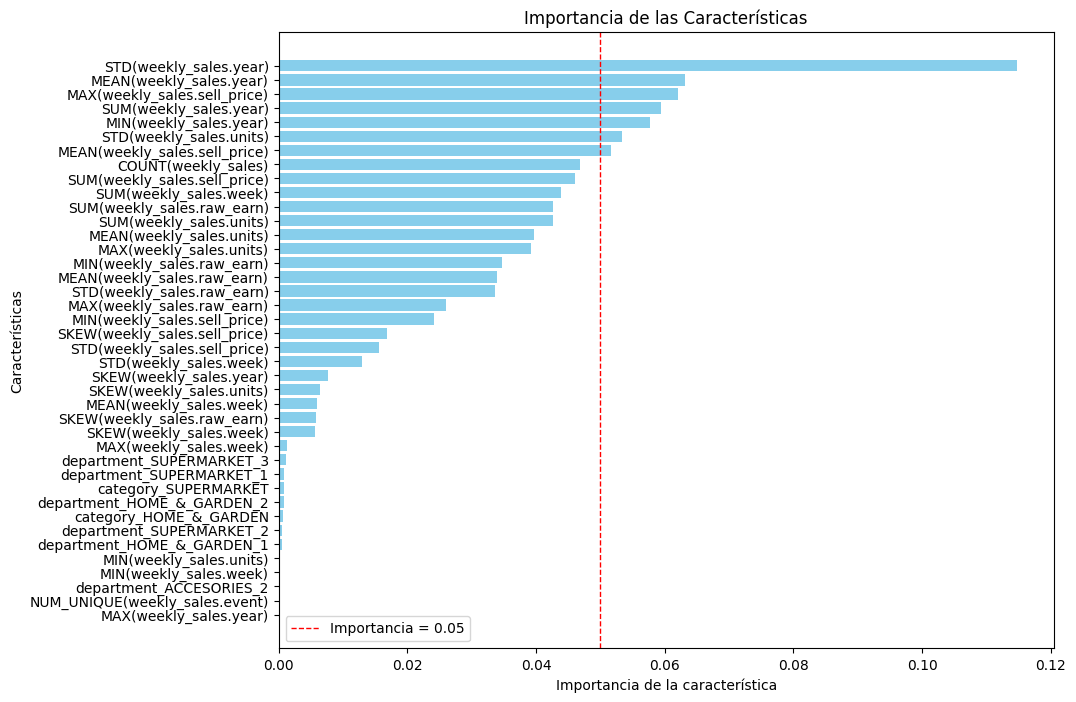

In [38]:
from sklearn.ensemble import RandomForestClassifier

clusters = kmeans.labels_

# Entrenar un Random Forest para predecir los clusters
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(scaled_df, clusters)

# Obtener importancias de las características
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# # Imprimir las características con sus importancias
# for i in indices:
#     print(f"{scaled_df.columns[i]}: {importances[i]}")

# Ordenar los índices y las importancias de mayor a menor
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = scaled_df.columns[sorted_indices]

# Crear el gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Importancia de la característica')
plt.ylabel('Características')
plt.title('Importancia de las Características')

# Invertir el eje y para que el mayor esté arriba
plt.gca().invert_yaxis()

imp_thresold = 0.05

# Añadir la línea discontinua roja vertical en imp_theesold
plt.axvline(x=imp_thresold, color='red', linestyle='--', linewidth=1, label=f'Importancia = {imp_thresold}')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

### 4.2. Analisis de los clusters

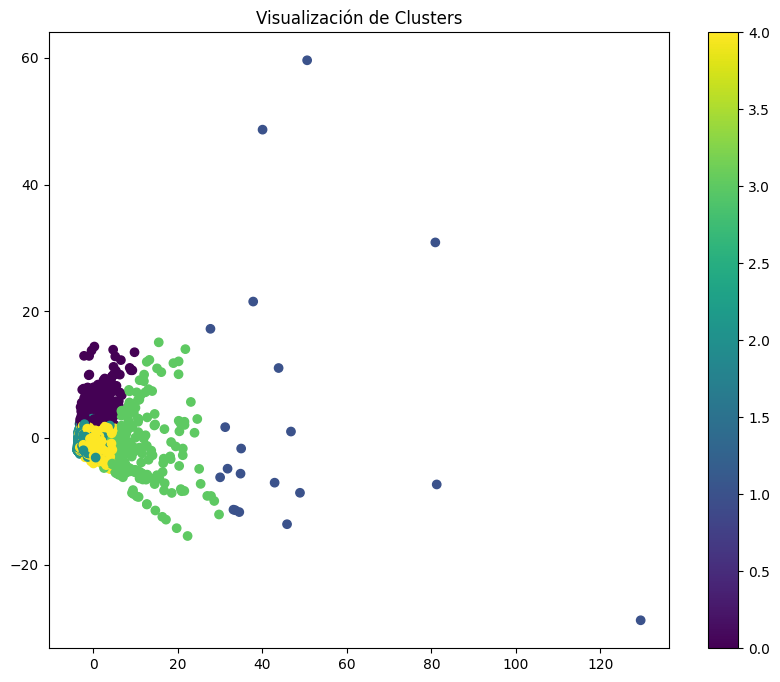

In [41]:
# PCA para visualización
pca = PCA(n_components=scaled_df.shape[1])
# pca.fit(scaled_df)

# pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_df)
# pca_df = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2'])

plt.figure(figsize=(10, 8))
# scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=df_items['Cluster'], cmap='viridis')
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=feature_matrix_products['Cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('Visualización de Clusters')
plt.show()


Principal Component 1: 0.49
Principal Component 2: 0.14
Principal Component 3: 0.07
Principal Component 4: 0.05
Principal Component 5: 0.04
Principal Component 6: 0.04
Principal Component 7: 0.04
Principal Component 8: 0.03
Principal Component 9: 0.02
Principal Component 10: 0.02
Principal Component 11: 0.01
Principal Component 12: 0.01
Principal Component 13: 0.01
Principal Component 14: 0.00
Principal Component 15: 0.00
Principal Component 16: 0.00
Principal Component 17: 0.00
Principal Component 18: 0.00
Principal Component 19: 0.00
Principal Component 20: 0.00
Principal Component 21: 0.00
Principal Component 22: 0.00
Principal Component 23: 0.00
Principal Component 24: 0.00
Principal Component 25: 0.00
Principal Component 26: 0.00
Principal Component 27: 0.00
Principal Component 28: 0.00
Principal Component 29: 0.00
Principal Component 30: 0.00
Principal Component 31: 0.00
Principal Component 32: 0.00
Principal Component 33: 0.00
Principal Component 34: 0.00
Principal Component 35:

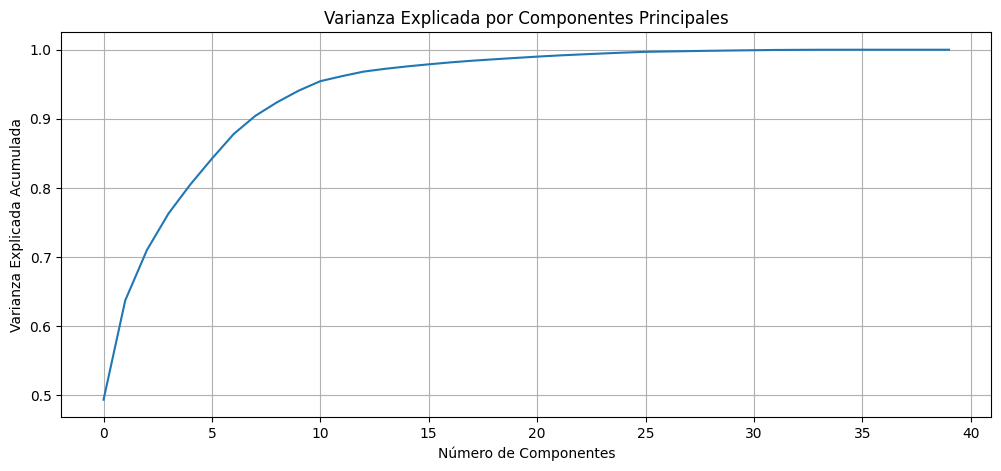

In [ ]:
# Ajustar PCA
pca = PCA(n_components=scaled_df.shape[1])
pca.fit(scaled_df)

# Imprimir la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
for i, var in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {var:.2f}")

# Graficar la varianza explicada acumulada
plt.figure(figsize=(12, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes Principales')
plt.grid(True)
plt.show()

#### **PCAs visualizaciones**  

URL original 
> https://towardsdatascience.com/5-pca-visualizations-you-must-try-on-your-next-data-science-project-148ec3d31e4d

Freedium
> https://freedium.cfd/https://towardsdatascience.com/5-pca-visualizations-you-must-try-on-your-next-data-science-project-148ec3d31e4d

# 5. DB SCAN

### 5.0 Creacion caracteristicas

In [13]:
es = ft.EntitySet(id="retail_data")

# Añadir entidades
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="ws", dataframe=df_ws, make_index=True, index="ws_id")

# Definir las relaciones entre tablas
es = es.add_relationship("shops", "store_code", "ws", "store_code")
es = es.add_relationship("items", "item", "ws", "item")

# Generar nuevas features con DFS
feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name="items")

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\entityset\entityset.py:393: UserWarning: Logical type Categorical for child column store_code does not match parent column store_code logical type Unknown. Changing child logical type to match parent.
  warnings.warn(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\entityset\entityset.py:393: UserWarning: Logical type Categorical for child column item does not match parent column item logical type Unknown. Changing child logical type to match parent.
  warnings.warn(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function max at 0x000001BA02

### 5.1 1ª Iteracion

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN

In [16]:
feature_matrix.head()

,category,department,COUNT(ws),MAX(ws.raw_earn),MAX(ws.sell_price),MAX(ws.units),MAX(ws.week),MAX(ws.year),MEAN(ws.raw_earn),MEAN(ws.sell_price),MEAN(ws.units),MEAN(ws.week),MEAN(ws.year),MIN(ws.raw_earn),MIN(ws.sell_price),MIN(ws.units),MIN(ws.week),MIN(ws.year),MODE(ws.event),NUM_UNIQUE(ws.event),SKEW(ws.raw_earn),SKEW(ws.sell_price),SKEW(ws.units),SKEW(ws.week),SKEW(ws.year),STD(ws.raw_earn),STD(ws.sell_price),STD(ws.units),STD(ws.week),STD(ws.year),SUM(ws.raw_earn),SUM(ws.sell_price),SUM(ws.units),SUM(ws.week),SUM(ws.year)
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,1185,142.82,12.74,13.00,53.00,2016.00,38.15,11.01,3.45,27.13,2014.46,10.99,6.65,1.00,1.00,2013.00,None,3,1.15,-7.11,1.16,-0.06,-0.02,24.62,0.19,2.24,15.69,0.90,44559.73,12862.35,4093.00,32148.00,2387135.00
ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1899,190.08,5.28,36.00,53.00,2016.00,14.09,5.28,2.66,27.79,2013.29,2.66,2.66,1.00,1.00,2011.00,None,3,4.29,-27.27,4.29,-0.12,0.04,11.68,0.09,2.21,15.15,1.46,26639.47,9972.82,5059.00,52774.00,3823243.00
ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,665,63.20,3.95,16.00,53.00,2016.00,8.51,3.94,2.16,23.95,2014.91,1.29,1.25,1.00,1.00,2014.00,None,3,3.07,-14.65,3.05,0.34,0.12,6.44,0.18,1.63,15.02,0.68,5533.73,2559.51,1435.00,15927.00,1339914.00
ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2512,506.04,6.17,82.00,53.00,2016.00,94.17,5.99,15.60,25.86,2013.22,5.01,5.01,1.00,1.00,2011.00,None,3,1.40,-1.67,1.35,0.08,0.07,79.00,0.27,12.96,15.16,1.52,234283.92,14892.93,39175.00,64962.00,5057201.00
ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,2134,141.61,4.10,42.00,53.00,2016.00,26.19,3.83,6.85,27.07,2013.46,3.30,2.65,1.00,1.00,2011.00,None,3,1.55,-0.80,1.78,-0.06,-0.11,18.45,0.23,4.94,15.36,1.52,55310.59,8079.94,14621.00,57757.00,4296731.00


In [19]:
# Identificar variables numéricas y categóricas
numeric_features = feature_matrix.select_dtypes(include=['int64', 'float64']).columns
categorical_features = feature_matrix.select_dtypes(include=['object', 'category', 'bool']).columns

# Pipeline para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputar valores faltantes con la mediana
    ('scaler', RobustScaler())  # Escalado robusto
])

# Pipeline para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación one-hot
])

# Combinar los pipelines en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aplicar el preprocesador
feature_matrix_preprocessed = preprocessor.fit_transform(feature_matrix)

In [20]:
# Aplicar DBSCAN
db = DBSCAN(eps=0.5, min_samples=2)
clusters = db.fit_predict(feature_matrix_preprocessed)

In [21]:
# Agregar clusters al DataFrame
feature_matrix['cluster'] = clusters

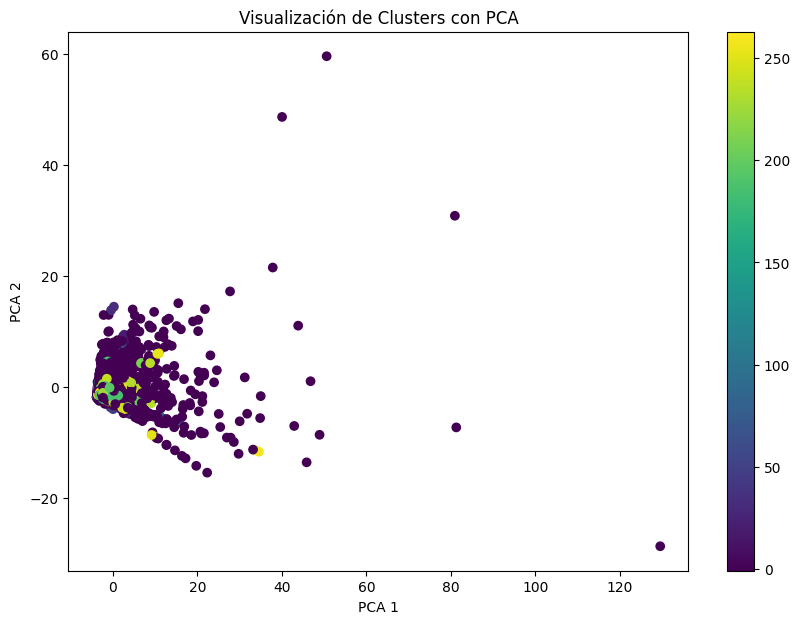

In [ ]:
# Paso 5: Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
components = pca.fit_transform(feature_matrix_preprocessed)

# Visualización de los clusters
plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de Clusters con PCA')
plt.colorbar()
plt.show()

In [32]:
feature_matrix['cluster'].value_counts()

cluster
-1     3023
 0        2
 1        2
 2        2
 3        2
 4        2
 5        2
 6        2
 7        2
 8        2
 9        2
 10       2
 11       2
 12       2
Name: count, dtype: int64

In [34]:
def find_best_dbscan_params(feature_matrix_preprocessed):
    best_params = None
    min_noise_points = len(feature_matrix_preprocessed)  # Inicializar con el número total de puntos
    best_silhouette = -1  # Inicializar con el peor Silhouette Score posible

    for eps in np.arange(0.1, 1.5, 0.1):
        for min_samples in range(2, 10):
            db = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = db.fit_predict(feature_matrix_preprocessed)
            
            # Calcular cuántos son considerados ruido
            n_noise = list(clusters).count(-1)
            
            # Calcular el coeficiente de silueta si hay más de 1 cluster
            if len(set(clusters)) > 1 and n_noise < len(clusters):
                silhouette_avg = silhouette_score(feature_matrix_preprocessed, clusters)
                
                # Si el número de puntos de ruido es menor, actualizar mejor resultado
                if n_noise < min_noise_points or (n_noise == min_noise_points and silhouette_avg > best_silhouette):
                    min_noise_points = n_noise
                    best_silhouette = silhouette_avg
                    best_params = {'eps': eps, 'min_samples': min_samples, 'silhouette_score': silhouette_avg, 'noise_points': n_noise}

    return best_params

In [35]:
# Ejecución de la función
best_dbscan_params = find_best_dbscan_params(feature_matrix_preprocessed)

# Mostrar los mejores parámetros y el número de puntos de ruido
print("Mejores parámetros:")
print(best_dbscan_params)

Mejores parámetros:
{'eps': 1.4000000000000001, 'min_samples': 2, 'silhouette_score': -0.3114767486822017, 'noise_points': 1988}


In [37]:
# Aplicar DBSCAN
db = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
clusters = db.fit_predict(feature_matrix_preprocessed)

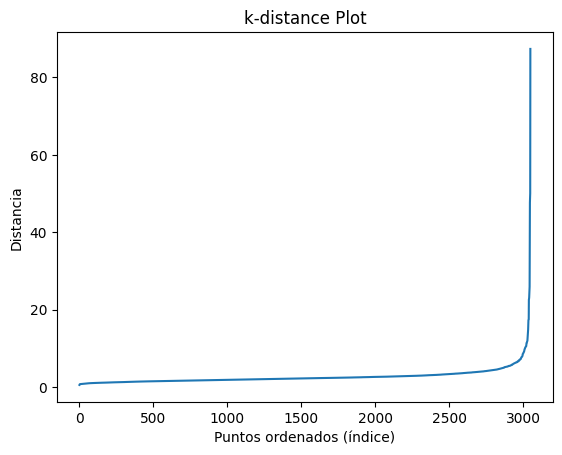

In [41]:
# Explorar la k-distance Plot para eps:
from sklearn.neighbors import NearestNeighbors

# Determinar el número de vecinos más cercanos
k = 4  # Puedes ajustar este valor dependiendo de tus datos
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(feature_matrix_preprocessed)
distances, indices = neighbors_fit.kneighbors(feature_matrix_preprocessed)

# Ordenar las distancias al k-ésimo vecino
distances = np.sort(distances[:, k-1], axis=0)

# Graficar las distancias
plt.plot(distances)
plt.ylabel('Distancia')
plt.xlabel('Puntos ordenados (índice)')
plt.title('k-distance Plot')
plt.show()


**Considerar min_samples más bajo:**  

Puedes intentar reducir min_samples aún más, aunque ya has probado con valores bajos, tal vez bajar a 1 o 2 si aún no lo has hecho.

**Preprocesamiento Adicional:**  

PCA: Has reducido la dimensionalidad a 2D solo para visualización. Considera aplicar PCA antes del clustering, pero manteniendo más componentes, por ejemplo, los que explican el 90% de la varianza.

In [61]:
pca = PCA(n_components=0.9)  # Mantener el 90% de la varianza

feature_matrix_pca = pca.fit_transform(feature_matrix_preprocessed)

# Luego aplicas DBSCAN u otro método de clustering
db = DBSCAN(eps=3, min_samples=1)
clusters = db.fit_predict(feature_matrix_pca)

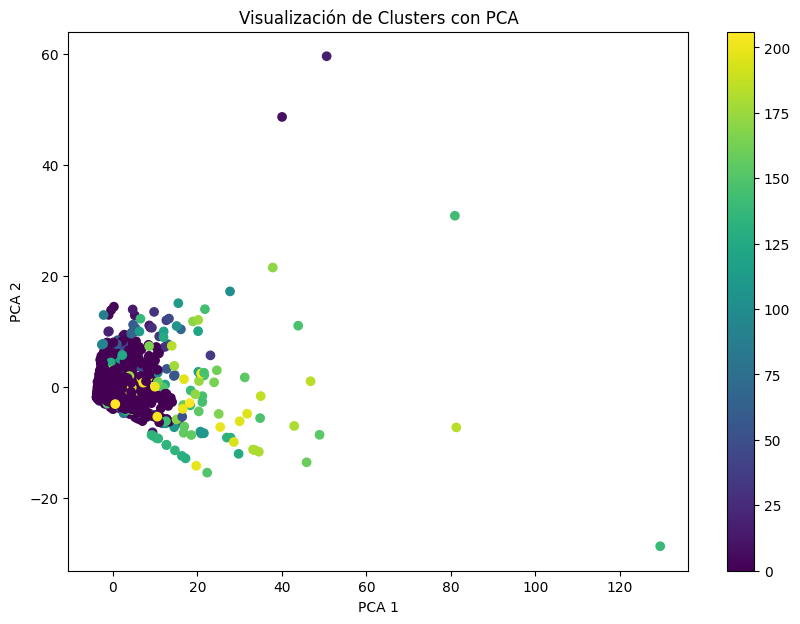

In [62]:
# Paso 5: Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
components = pca.fit_transform(feature_matrix_pca)

# Visualización de los clusters
plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de Clusters con PCA')
plt.colorbar()
plt.show()

In [63]:
best_dbscan_params = find_best_dbscan_params(feature_matrix_pca)

# Mostrar los mejores parámetros y el número de puntos de ruido
print("Mejores parámetros:")
print(best_dbscan_params)

eps = best_dbscan_params['eps']
min_samples = best_dbscan_params['min_samples']

db = DBSCAN(eps=eps, min_samples=min_samples)
clusters = db.fit_predict(feature_matrix_pca)

Mejores parámetros:
{'eps': 1.4000000000000001, 'min_samples': 2, 'silhouette_score': -0.3657163620190041, 'noise_points': 995}


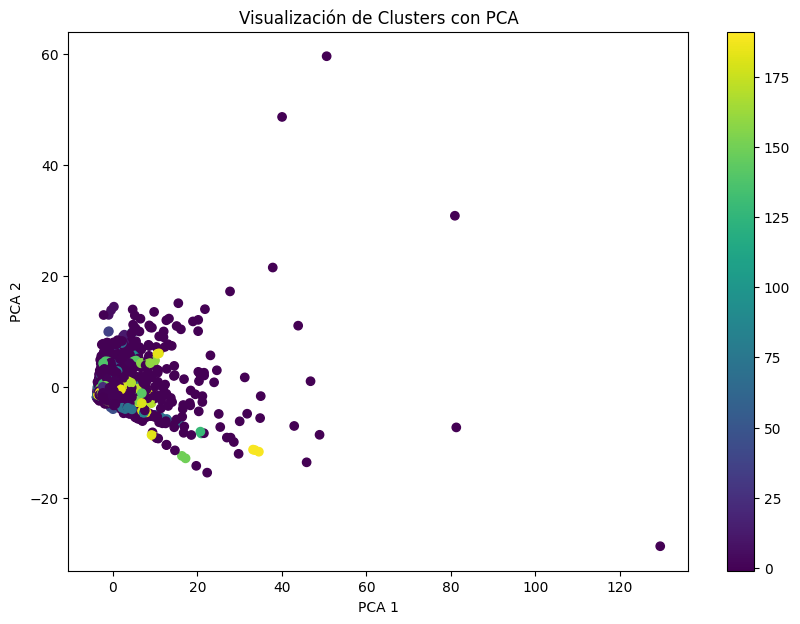

In [64]:
# Paso 5: Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
components = pca.fit_transform(feature_matrix_pca)

# Visualización de los clusters
plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de Clusters con PCA')
plt.colorbar()
plt.show()

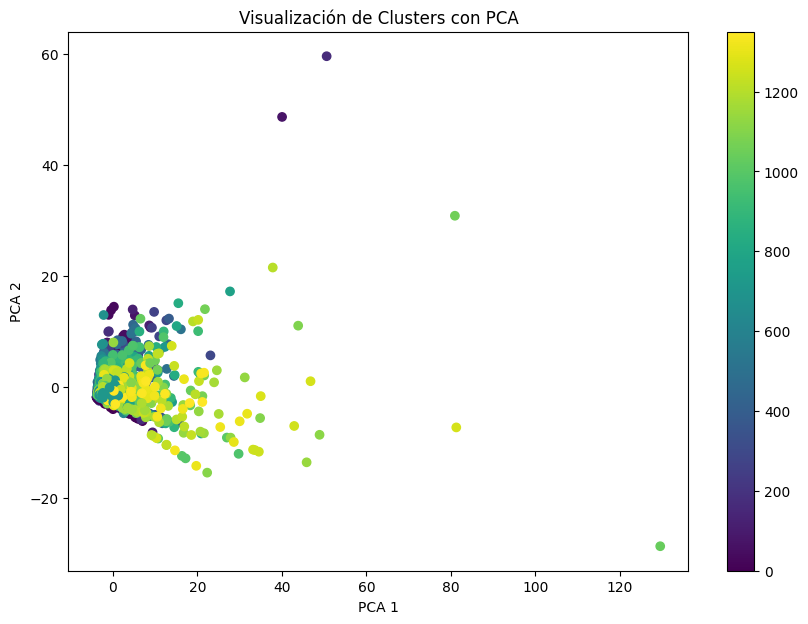

In [71]:
eps = 2
min_samples = 1

feature_matrix = feature_matrix_preprocessed
# feature_matrix = feature_matrix_pca

db = DBSCAN(eps=eps, min_samples=min_samples)
clusters = db.fit_predict(feature_matrix)

pca = PCA(n_components=2)
components = pca.fit_transform(feature_matrix)

# Visualización de los clusters
plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de Clusters con PCA')
plt.colorbar()
plt.show()

In [75]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.5)
clusters = optics.fit_predict(feature_matrix_preprocessed)

n_noise = list(clusters).count(-1)
print(f"Número de puntos de ruido con OPTICS: {n_noise}")


Número de puntos de ruido con OPTICS: 0


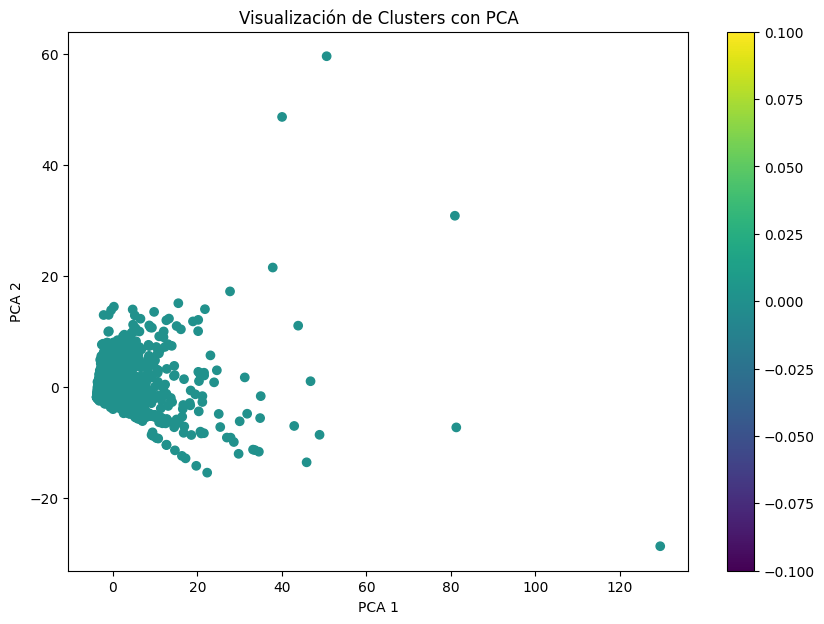

In [76]:
pca = PCA(n_components=2)
components = pca.fit_transform(feature_matrix)

# Visualización de los clusters
plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de Clusters con PCA')
plt.colorbar()
plt.show()

### 5.2 Validaciones

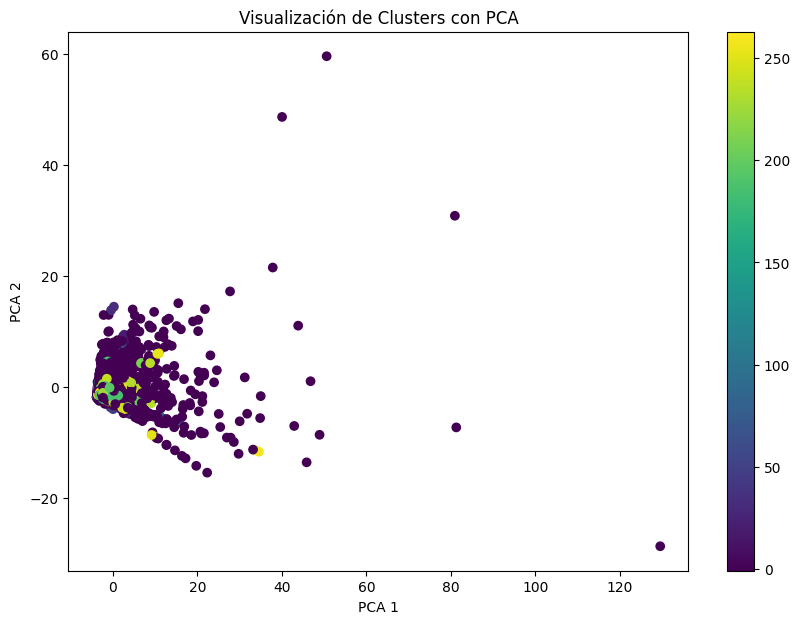

In [38]:
# Paso 5: Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
components = pca.fit_transform(feature_matrix_preprocessed)

# Visualización de los clusters
plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de Clusters con PCA')
plt.colorbar()
plt.show()

**Davies-Bouldin Index**:

-   Mide la media de la razón de la suma de las dispersiónes intra-cluster a las distancias entre clusters.
-   Valores más bajos indican mejores clusters.

In [ ]:
from sklearn.metrics import davies_bouldin_score

X = 

db_index = davies_bouldin_score(X, labels)
print(f'Davies-Bouldin Index: {db_index}')

**Calinski-Harabasz Index**:

-   También conocido como el criterio de la relación de varianza.
-   Cuanto más alto sea el valor, mejor es la separación entre los clusters.

In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(X, labels)
print(f'Calinski-Harabasz Index: {ch_score}')


### 5.3 Descripción de los Clusters

**Número de Clusters y Puntos Ruido**:

-   Contar el número de clusters formados (excluyendo puntos ruido).
-   Contar el número de puntos marcados como ruido.

In [ ]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters: {n_clusters}')
print(f'Número de puntos ruido: {n_noise}')


**Tamaño de los Clusters**:

-   Contar el número de puntos en cada cluster.

In [ ]:
from collections import Counter

cluster_sizes = Counter(labels)
print(f'Tamaño de los clusters: {cluster_sizes}')


**Centroides de los Clusters**:

-   Calcular el centroide (media) de cada cluster para entender su posición.

In [ ]:
df_centroids = pd.DataFrame(X, columns=['feature1', 'feature2'])
df_centroids['cluster'] = labels

centroids = df_centroids.groupby('cluster').mean()
print(f'Centroides de los clusters:\n{centroids}')


**Visualización**

In [ ]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette="viridis", legend="full")
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


### 5.4 Analisis PCA (y otros)

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

# Varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
print(f'Varianza explicada por las dos primeras componentes principales: {explained_variance}')

# Cargar de características en las componentes principales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Crear un DataFrame para visualizar las cargas
features = feature_matrix.columns
loadings_df = pd.DataFrame(loadings, index=features, columns=['PC1', 'PC2'])
print(loadings_df)

# Visualización de las cargas de las características en las dos primeras componentes principales
plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering con PCA')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
# Visualización y Análisis Descriptivo

## Añadir las etiquetas de los clusters al DataFrame original
# db_items['cluster'] = labels # Hecho antes?

# Visualizar la distribución de las características por cluster
for feature in feature_matrix_products.columns:
    plt.figure(figsize=(10, 7))
    sns.boxplot(x='cluster', y=feature, data=feature_matrix_products)
    plt.title(f'Distribución de {feature} por Cluster')
    plt.show()


In [ ]:
# Analisis de correlacion
# Calcular las correlaciones
# correlations = db_items.corr()
correlations = feature_matrix_products.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Características')
plt.show()


# **Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans

# Definir las columnas categóricas y numéricas
categorical_columns = feature_matrix_products.select_dtypes(include=['object']).columns.tolist()
numeric_columns = feature_matrix_products.select_dtypes(include=[float, int]).columns.tolist()

# Crear un preprocesador que maneje la codificación y el escalado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Crear el pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=42))  # Cambia n_clusters según lo que hayas encontrado óptimo
])

# Entrenar el pipeline con los datos
pipeline.fit(feature_matrix_products)

# Predecimos clusters
predictions = pipeline.predict(feature_matrix_products)

# Para predecir clusters en nuevos datos:
# predictions = pipeline.predict(nuevos_datos_df)
